In [ ]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [ ]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)
hist.head(10)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2021-12-16,63330.12,60572.73,62857.11,3133.99,1.952290e+08,60755.16
2021-12-17,61529.42,58313.91,60755.16,4096.66,2.474348e+08,59684.29
2021-12-18,61155.13,58552.88,59684.29,3366.64,2.024930e+08,60236.94
2021-12-19,62437.33,59720.02,60236.94,3699.28,2.248559e+08,60080.02
2021-12-20,61647.06,58802.16,60080.02,4236.81,2.544447e+08,60779.69
2021-12-21,63896.21,60216.05,60779.69,4291.43,2.685774e+08,63331.17
2021-12-22,64157.28,62213.97,63331.17,4229.39,2.669428e+08,62591.60
2021-12-23,65978.62,61510.78,62591.60,4485.27,2.825746e+08,64994.90
2021-12-24,66607.23,64456.64,64994.90,3139.00,2.053367e+08,65209.73


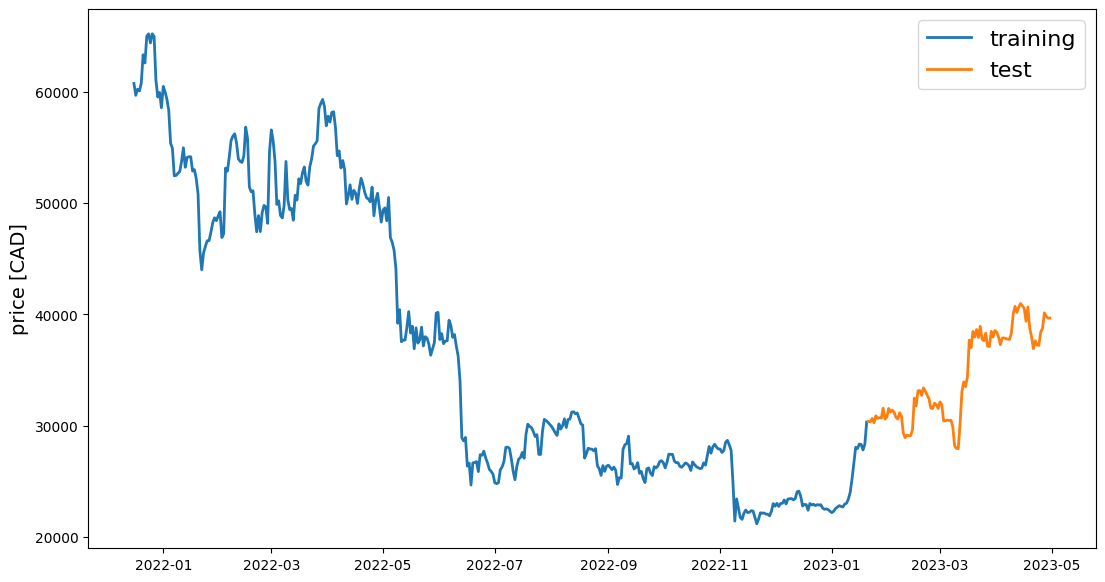

In [ ]:
def train_test_split(df, test_size=0.2):
  split_row = len(df) - int(test_size * len(df))
  train_data = df.iloc[:split_row]
  test_data = df.iloc[split_row:]
  return train_data, test_data
train, test = train_test_split(hist, test_size=0.2)
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
  fig, ax = plt.subplots(1, figsize=(13, 7))
  ax.plot(line1, label=label1, linewidth=lw)
  ax.plot(line2, label=label2, linewidth=lw)
  ax.set_ylabel('price [CAD]', fontsize=14)
  ax.set_title(title, fontsize=16)
  ax.legend(loc='best', fontsize=16);
line_plot(train[target_col], test[target_col], 'training', 'test', title= '')

In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1
def normalise_min_max(df):
  return (df - df.min()) / (data.max() - df.min())
def extract_window_data(df, window_len=5, zero_base=True):
  window_data = []
  for idx in range(len(df) - window_len):
    tmp = df[idx: (idx + window_len)].copy()
    if zero_base:
      tmp = normalise_zero_base(tmp)
      window_data.append(tmp.values)
  return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size =0.2):
  train_data, test_data = train_test_split(df, test_size=test_size)
  X_train = extract_window_data(train_data, window_len, zero_base)
  X_test = extract_window_data(test_data, window_len, zero_base)
  y_train = train_data[target_col][window_len:].values
  y_test = test_data[target_col][window_len:].values
  if zero_base:
    y_train = y_train / train_data[target_col][:-window_len].values - 1
    y_test = y_test / test_data[target_col][:-window_len].values - 1
  return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
  model = Sequential()
  model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data. shape[2])))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss=loss, optimizer=optimizer)
  return model

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,optimizer=optimizer)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 3s 50ms/step - loss: 0.0055 - val_loss: 0.0039
Epoch 2/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 3/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 4/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 5/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 6/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 7/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 8/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 9/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 10/20
13/13 [==============================] - 0s 15ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 11/20
1

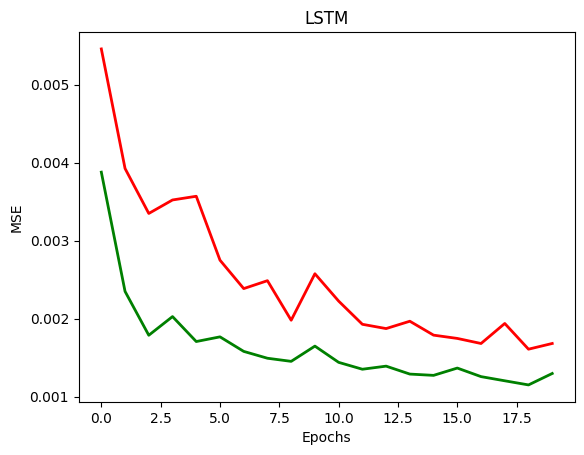

3/3 [==============================] - 0s 4ms/step


0.023085756567839313

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

In [ ]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7317610357077389

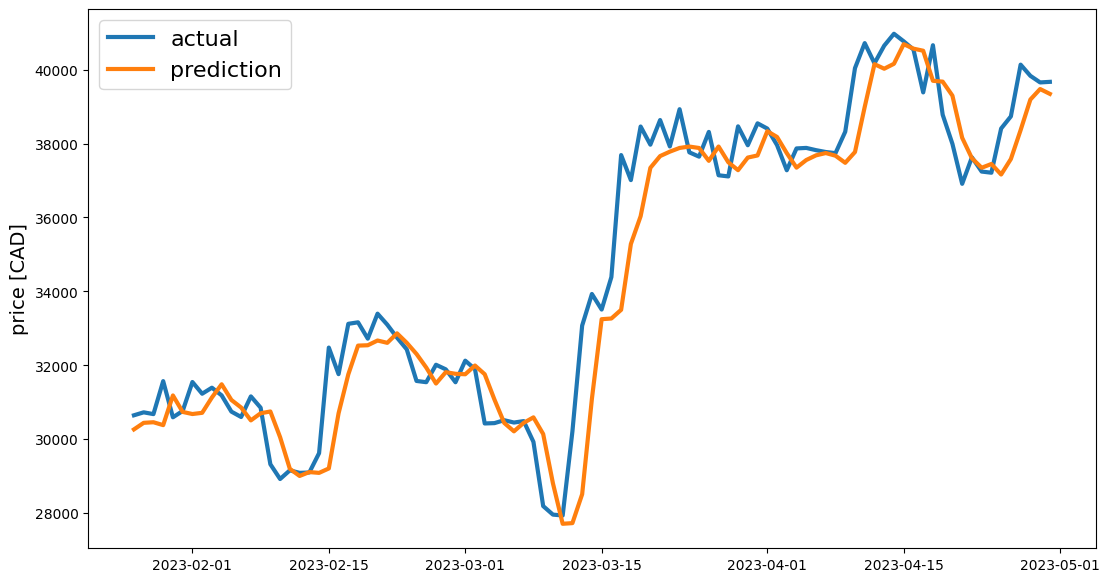

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [ ]:
def predict_and_trade(model, data, prices):
    # Predict the price changes
    changes = model.predict(data)

    # Initialize variables to track the trading position and buy/sell times
    positions = [0]
    buy_times = []
    sell_times = []

    # Loop over the price changes
    for i in range(len(changes)):
        # Compute the predicted price and the actual price
        pred_price = prices[i] + changes[i]
        actual_price = prices[i + 1]

        # If the predicted price is higher than the actual price, buy
        if pred_price > actual_price:
            positions.append(1)
            buy_times.append(prices.index[i + 1])
        # Otherwise, sell
        else:
            positions.append(0)
            sell_times.append(prices.index[i + 1])

    # Return the trading positions and buy/sell times
    return positions, buy_times, sell_times


In [ ]:
import pandas as pd
import numpy as np

def sma_crossover_strategy(df, short_window=50, long_window=200):
    # Calculate the short and long SMAs
    df['SMA_short'] = df['Close'].rolling(window=short_window).mean()
    df['SMA_long'] = df['Close'].rolling(window=long_window).mean()

    # Generate buy and sell signals
    df['Signal'] = np.where(df['SMA_short'] > df['SMA_long'], 1, -1)
    df['Signal_shifted'] = df['Signal'].shift(1)
    df['Buy'] = np.where((df['Signal'] > df['Signal_shifted']) & (df['Signal'] > 0), df['Close'], np.nan)
    df['Sell'] = np.where((df['Signal'] < df['Signal_shifted']) & (df['Signal'] < 0), df['Close'], np.nan)

    # Set initial position to zero
    df['Position'] = 0

    # Fill in positions for buy and sell signals
    df.loc[df['Buy'].notnull(), 'Position'] = 1
    df.loc[df['Sell'].notnull(), 'Position'] = -1

    # Forward fill positions to simulate holding
    df['Position'].ffill(inplace=True)

    return df


In [ ]:
import requests
import pandas as pd

url = 'https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=CAD&limit=500'
response = requests.get(url)

if response.status_code == 200:
    data = response.json()['Data']
    df = pd.DataFrame.from_dict(data)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    df.index.name = None
    target_col = 'close'
    df.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

    # Define moving average crossover strategy
    short_window = 50
    long_window = 200
    df['short_ma'] = df[target_col].rolling(window=short_window).mean()
    df['long_ma'] = df[target_col].rolling(window=long_window).mean()

    # Calculate signals based on moving average crossover
    df['signal'] = 0.0
    df['signal'][short_window:] = np.where(df['short_ma'][short_window:] > df['long_ma'][short_window:], 1.0, 0.0)

    # Calculate positions based on signals
    df['positions'] = df['signal'].diff()

    # Backtest strategy and calculate profit/loss
    initial_capital = 1000.0
    positions = pd.Series(index=df.index, data=0.0)
    positions.iloc[0] = 0.0
    positions.iloc[1:] = np.sign(df['positions'].values[:-1])
    portfolio = positions * df[target_col]
    pos_diff = positions.diff()
    portfolio.iloc[0] = initial_capital
    portfolio.iloc[0] -= abs(pos_diff.iloc[0]) * df[target_col].iloc[0]
    portfolio = portfolio.cumsum()
    returns = portfolio.pct_change()
    print(f'Total profit/loss: {portfolio.iloc[-1] - initial_capital:.2f}')


Total profit/loss: 30158.56


In [ ]:
import requests
import pandas as pd

# Set the API endpoint and parameters
url = 'https://min-api.cryptocompare.com/data/histoday'
params = {'fsym': 'BTC', 'tsym': 'CAD', 'limit': 500}

# Make the API request and parse the response
response = requests.get(url, params=params)
data = response.json()['Data']

# Convert the data to a DataFrame
df = pd.DataFrame.from_dict(data)

# Convert the timestamp to a datetime object and set it as the index
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# Apply the trading strategy
df_btc = sma_crossover_strategy(df_btc)

# Print the buy and sell signals with Timestamp
print(df_btc.loc[df_btc['Buy'].notnull() | df_btc['Sell'].notnull(), ['Buy', 'Sell']].reset_index())

if response.status_code == 200:
    data = response.json()['Data']
    df = pd.DataFrame.from_dict(data)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    df.index.name = None
    target_col = 'close'
    df.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

    # Define moving average crossover strategy
    short_window = 50
    long_window = 200
    df['short_ma'] = df[target_col].rolling(window=short_window).mean()
    df['long_ma'] = df[target_col].rolling(window=long_window).mean()

    # Calculate signals based on moving average crossover
    df['signal'] = 0.0
    df['signal'][short_window:] = np.where(df['short_ma'][short_window:] > df['long_ma'][short_window:], 1.0, 0.0)

    # Calculate positions based on signals
    df['positions'] = df['signal'].diff()

    # Backtest strategy and calculate profit/loss
    initial_capital = 50.0
    positions = pd.Series(index=df.index, data=0.0)
    positions.iloc[0] = 0.0
    positions.iloc[1:] = np.sign(df['positions'].values[:-1])
    portfolio = positions * df[target_col]
    pos_diff = positions.diff()
    portfolio.iloc[0] = initial_capital
    portfolio.iloc[0] -= abs(pos_diff.iloc[0]) * df[target_col].iloc[0]
    portfolio = portfolio.cumsum()
    returns = portfolio.pct_change()
    print(f'Total profit/loss: {portfolio.iloc[-1] - initial_capital:.2f}')


         Date           Buy          Sell
0  2017-07-19   2273.429932           NaN
1  2018-03-30           NaN   6890.520020
2  2019-04-24   5464.866699           NaN
3  2019-10-26           NaN   9244.972656
4  2020-02-19   9633.386719           NaN
5  2020-03-25           NaN   6681.062988
6  2020-05-21   9081.761719           NaN
7  2021-06-19           NaN  35615.871094
8  2021-09-15  48176.347656           NaN
9  2022-01-14           NaN  43099.699219
10 2023-02-07  23264.291016           NaN
Total profit/loss: 31108.56


<ipython-input-5-857b2de749ba>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][short_window:] = np.where(df['short_ma'][short_window:] > df['long_ma'][short_window:], 1.0, 0.0)


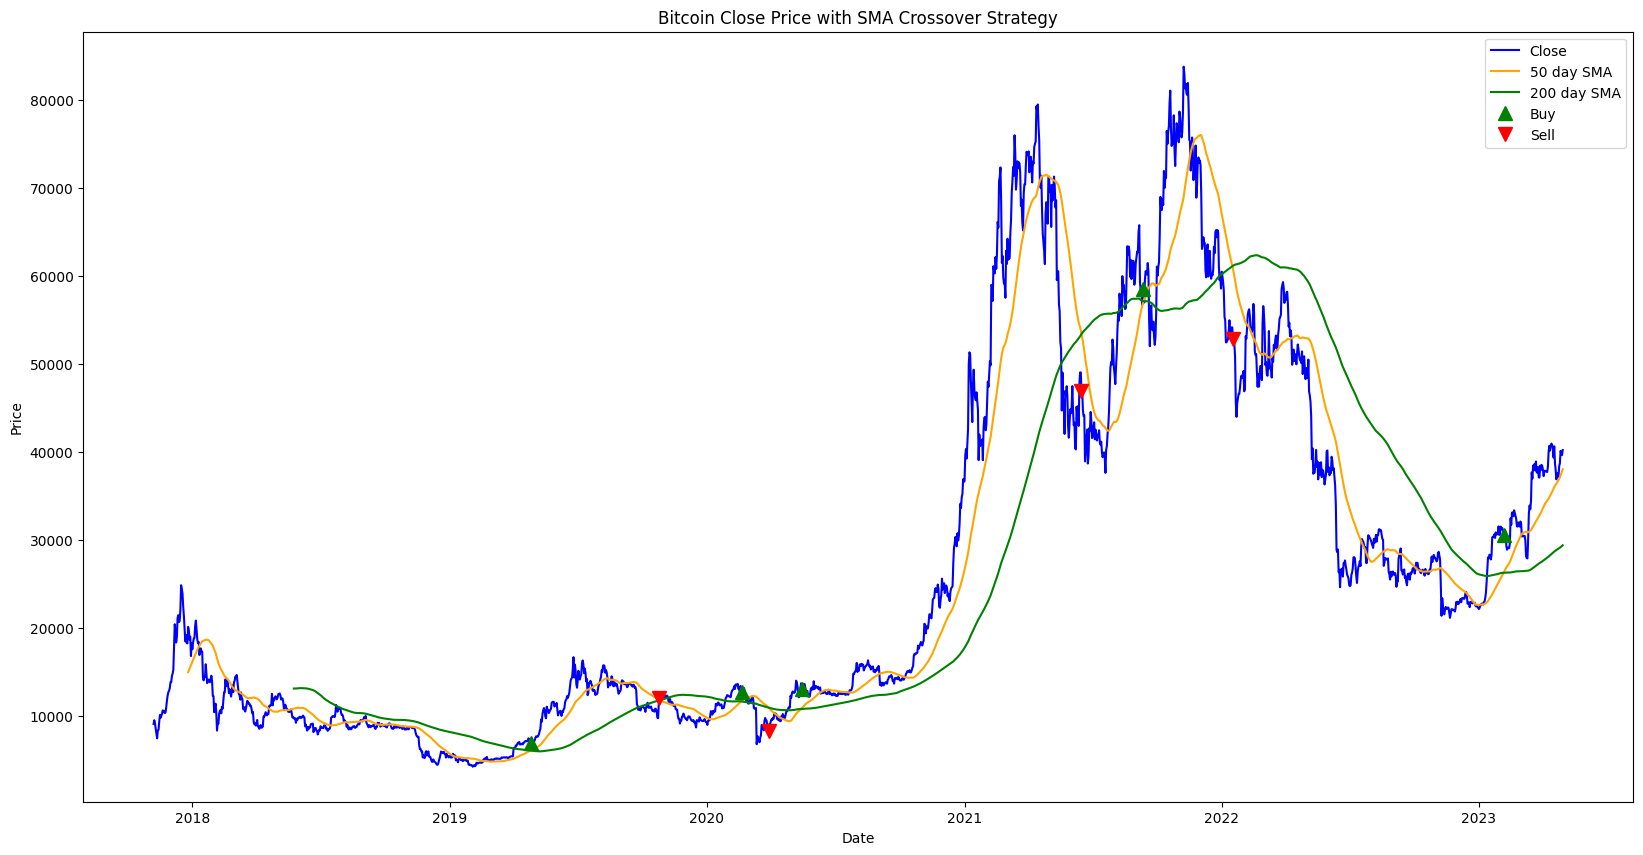

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set the API endpoint and parameters
url = 'https://min-api.cryptocompare.com/data/histoday'
params = {'fsym': 'BTC', 'tsym': 'CAD', 'limit': 2000}

# Make the API request and parse the response
response = requests.get(url, params=params)
data = response.json()['Data']

# Convert the data to a DataFrame
df = pd.DataFrame.from_dict(data)

# Convert the timestamp to a datetime object and set it as the index
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

def sma_crossover_strategy(df, short_window=50, long_window=200):
    # Define moving average crossover strategy
    df['short_ma'] = df['close'].rolling(window=short_window).mean()
    df['long_ma'] = df['close'].rolling(window=long_window).mean()

    # Calculate signals based on moving average crossover
    df['signal'] = 0.0
    df['signal'][short_window:] = np.where(df['short_ma'][short_window:] > df['long_ma'][short_window:], 1.0, 0.0)

    # Calculate positions based on signals
    df['positions'] = df['signal'].diff()

    # Backtest strategy and calculate profit/loss
    initial_capital = 10000.0
    positions = pd.Series(index=df.index, data=0.0)
    positions.iloc[0] = 0.0
    positions.iloc[1:] = np.sign(df['positions'].values[:-1])
    portfolio = positions * df['close']
    pos_diff = positions.diff()
    portfolio.iloc[0] = initial_capital
    portfolio.iloc[0] -= abs(pos_diff.iloc[0]) * df['close'].iloc[0]
    portfolio = portfolio.cumsum()
    returns = portfolio.pct_change()

    # Add Buy and Sell signals to the DataFrame
    df.loc[df['positions'] == 1.0, 'Buy'] = df['close']
    df.loc[df['positions'] == -1.0, 'Sell'] = df['close']

    # Plot the data and the Buy/Sell signals
    plt.figure(figsize=(20,10))
    plt.plot(df['close'], color='blue', label='Close')
    plt.plot(df['short_ma'], color='orange', label=f'{short_window} day SMA')
    plt.plot(df['long_ma'], color='green', label=f'{long_window} day SMA')
    plt.plot(df['Buy'], '^', markersize=10, color='green', label='Buy')
    plt.plot(df['Sell'], 'v', markersize=10, color='red', label='Sell')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Bitcoin Close Price with SMA Crossover Strategy')
    plt.legend()
    plt.show()

# Apply the trading strategy and plot the graph
df_2015 = df.loc[df.index >= '2015-01-01']
sma_crossover_strategy(df_2015)
